In [1]:
#Practice with some ConvNets
#This ipython also assumes you have decent knowledge of ConvNets. This article should be good enough for now: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [2]:
#Let's import libraries 
import tensorflow as tf
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

(50000, 32, 32, 3)


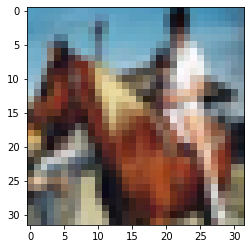

In [3]:
#We'll start with MNIST first

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = unpickle('cifar-10-batches-py/data_batch_1')

#train data
x_train = []
for prefix in range(1,6):
    data = unpickle('cifar-10-batches-py/data_batch_'+str(prefix))
    for i in range(data[b'data'].shape[0]):
        im1 = data[b'data'][i][:1024].reshape(32,32)
        im2 = data[b'data'][i][1024:2048].reshape(32,32)
        im3 = data[b'data'][i][2048:].reshape(32,32)
        im = np.dstack((im1,im2,im3))
        x_train.append(im)

x_train = np.array(x_train)

np.random.seed(0)
np.random.shuffle(x_train)

#test data
x_test = []
data = unpickle('cifar-10-batches-py/test_batch')
for i in range(data[b'data'].shape[0]):
    im1 = data[b'data'][i][:1024].reshape(32,32)
    im2 = data[b'data'][i][1024:2048].reshape(32,32)
    im3 = data[b'data'][i][2048:].reshape(32,32)
    im = np.dstack((im1,im2,im3))
    x_test.append(im)

x_test = np.array(x_test)

np.random.shuffle(x_test)

print(x_train.shape)
                              
plt.imshow(x_train[0])
plt.show()

In [4]:
#Don't forget to scale values
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
#Ok so far we've just been doing the same things as our previous notebook. Let's actually get into the meat of ConvNets.
#Again, it would be good if you understand just somewhat intuitively what ConvNets do each layer before coding

In [6]:
#define our convnet model
def ConvNet(inputs):
    #encoding
    c1 = tf.layers.conv2d(inputs=inputs, filters=16, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
    p1 = tf.layers.max_pooling2d(inputs=c1,pool_size=(2,2),strides=(2,2),padding='valid')
    
    c2 = tf.layers.conv2d(inputs=p1, filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
    p2 = tf.layers.max_pooling2d(inputs=c2,pool_size=(2,2),strides=(2,2),padding='valid')
    
    d3 = tf.layers.dense(inputs=tf.layers.flatten(p2), units=512, activation=tf.nn.relu)
    #d3 - representation
    #starting decode
    d4 = tf.layers.dense(inputs=d3, units=8*8*32, activation=tf.nn.relu)
    
    tc5 = tf.layers.conv2d_transpose(inputs=tf.reshape(d4,(-1,8,8,32)), strides=(2,2), filters=16, kernel_size=(3,3), activation=tf.nn.relu, padding='same')
    
    tc6 = tf.layers.conv2d_transpose(inputs=tc5, filters=3, strides=(2,2), kernel_size=(3,3), activation=tf.nn.sigmoid, padding='same')
    
    return tc6

In [7]:
#Now let's walk through the same model building as last time
inputs=tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
#We define our input differently in this case

labels = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

outputs = ConvNet(inputs)

loss = tf.reduce_mean(tf.pow(outputs - inputs, 2))

trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

#Let's set some hyperparamaters for batch size and epochs
batch_size = 128
num_epochs = 20
    

Starting to run session...
0.0137376245
0.010021109
0.008803821
0.007928096
0.0074121365
0.006741998
0.0063851625
0.006069516
0.0058711627
0.005624735
0.005636638
0.005368143
0.0052306787
0.005111869
0.004951837
0.004964586
0.004881591
0.0046749082
0.0046345736
0.0045648785


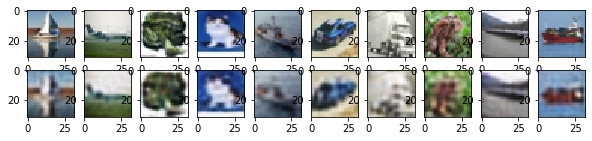

<Figure size 432x288 with 0 Axes>

In [8]:
init=tf.global_variables_initializer()
local_init = tf.local_variables_initializer()
with tf.Session() as sess:
    #each call to sess.run() runs the approriate input within our tf session
    sess.run(init)
    sess.run(local_init)
    print("Starting to run session...")
    for epoch in range(num_epochs): #iterate through each epoch
        for i in range(x_train.shape[0]//batch_size): #iterate through the number of batches we can make from our samples
            batch_images = x_train[i*batch_size:(i+1)*batch_size]
            #We have a batch of training images and labels. 
            #Now we need to run the model by inputing these into the place holders we made
            _ = sess.run([trainer], feed_dict={inputs: batch_images, labels: batch_images})
        #Checking our accuracy each epoch...
        l = sess.run(
            loss, feed_dict={inputs: x_test})
        print(l)
        
    pred = sess.run(
            outputs, feed_dict={inputs: x_test})
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        a[0][i].imshow(np.reshape(x_test[i], (32, 32,3)))
        a[1][i].imshow(np.reshape(pred[i], (32, 32, 3)))
    plt.show()
    plt.draw()
        # Compare original images with their reconstructions
